In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf
import numpy as np
#import scipy.special as sci
import matplotlib.pyplot as plt
import pickle#5 as pickle
import imagesc as imagesc

import scipy.stats as stats
from scipy import stats
import matplotlib as mpl  
# import seaborn as sns
# sns.set(style='whitegrid')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
#tf.compat.v1.random.set_random_seed(1234)
tf.random.set_random_seed(0)
np.random.seed(seed=1234 )

In [4]:

T_step=1001
N_bead=300
dim_x=900
N_conf=0


ex_mean,ex_std= 208.21994500581388 ,69.79624239435213
t0=0
t1=0.5
dt=(t1-t0)/(T_step-1)
vect=np.linspace(t0,t1,T_step)

In [5]:
dic='../data'
N_tra=500
Z1_test=np.loadtxt(dic+'Z1_test_result241.txt')
np.savetxt('Z1_test.txt',np.array( Z1_test ),fmt='%10.5e')

In [6]:
Z1_test.shape

(500, 1001)

In [7]:
N_tra=500
# data_230=pickle.load(open('/storage/Xiaoli/DNA_test_data/DNA_mean/ex_test_result241.pkl', 'rb'))
# Z1_test230=data_230['Wi5']
# z_230=(Z1_test230-z_mean)/z_std
#np.savetxt('Z1_test.txt',np.array( Z1_test230),fmt='%10.5e')

In [8]:
def generate_data_1trajectory(path,N0,N1):
   # path = '../config_meta.pkl'
    N_tra=N1-N0
    a_tra=np.linspace(N0,N1-1,N1-N0,dtype=int)
    data = pickle.load(open(path, 'rb'))
    a_test=np.linspace(0,2,3 ,dtype=int)
    X_all_t0=np.zeros([(T_step-1)*N_tra ,3*N_bead])
    X_all_t1=np.zeros([(T_step-1)*N_tra ,3*N_bead])
    X_all=np.zeros([T_step*N_tra ,3*N_bead])#500500*900
    L_test=np.linspace(0,T_step-1,T_step,dtype=int)
    for i in a_tra:
        X_all_1=np.zeros([T_step ,3*N_bead])#1001*900
        W_1=data['Trajectory' + str(i+1) ]
        for j in range(N_bead):
            XX=np.reshape(W_1[:,j],[1001,3])
            X_all_1[:,a_test+3*j]=XX
        X_all[(i-N0)*T_step+L_test,:]=X_all_1
        X_all_t0[(i-N0)*(T_step-1)+L_test[:-1],:]=X_all_1[:-1,:]
        X_all_t1[(i-N0)*(T_step-1)+L_test[:-1],:]=X_all_1[1:,:]
    return X_all_t0,X_all_t1,X_all

In [9]:
def neural_autoencoder(X, weights, biases ):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = np.tanh(np.add(np.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    H =  (np.add(np.matmul(H, W), b))
    return H

In [10]:
path_tra =dic+'/config_test_result241_mean_every.pkl'
X_trajectory_test230=generate_data_1trajectory(path_tra,0,N_tra)#Z0 Z1 Z_all

def neural_low(X, weights_encoder, biases_encoder,weights_L):
    X_low_PCA=X @weights_L[0]
    X_low_encoder= neural_autoencoder(X,weights_encoder, biases_encoder)
    return X_low_PCA+X_low_encoder
# Z2_pca_test230=X_trajectory_test230[2] @ pca_1
# Z2_230=Z2_pca_test230
# np.savetxt('X_low_test_result241.txt',np.array( Z2_230),fmt='%10.5e')

In [11]:
data=pickle.load(open('../save_checkpoints/hyper100000.pkl', 'rb'))
weights_potential = data["weights_potential"]
biases_potential =  data["biases_potential"]
Gamma = data["Gamma"]
beta=data["beta"]
weights_A= data["weights_A"]
biases_A = data["biases_A"]
weights_L= data["weights_L"] 
sigma=data["sigma"]
weights_encoder=data["weights_encoder"]
biases_encoder=data["biases_encoder"]
weights_decoder=data["weights_decoder"]
biases_decoder=data["biases_decoder"]
alpha=0.1

In [12]:
X_trajectory_test230[2].shape

(500500, 900)

In [13]:
X_low=neural_low(X_trajectory_test230[2], weights_encoder, biases_encoder,weights_L)
Z2_test=np.reshape(X_low[:,0],[N_tra,T_step]   )
Z3_test=np.reshape(X_low[:,1],[N_tra,T_step]   )
np.savetxt('Z2_test.txt',np.array( Z2_test),fmt='%10.5e')
np.savetxt('Z3_test.txt',np.array( Z3_test),fmt='%10.5e')

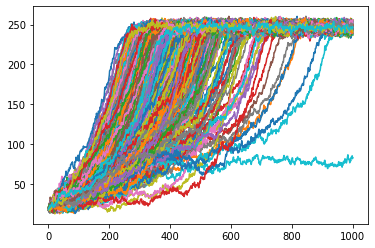

In [14]:
for i in range(N_tra):
    plt.plot(Z1_test[i,:])

In [15]:
def relu(inputs):
    return np.maximum(inputs,0)
def RePU(inputs):
    """Rectified Power Unit Activation

    z->max(0,z)^p
    """
    return (relu(inputs)  )**2


def ShiftedRePU(inputs):
    """Shifted Rectified Power Unit Activation

    z->max(0,z)^p - max(0,z-0.5)^p
    """
    g=(relu(inputs)  )**2-(relu(inputs-0.5)  )**2
    return g

Neural network for potential term
$V(x)=\beta  ||x||^2 +\frac{1}{2} \sum_{i=1}^{m} (U_i(x)+\sum_{j=1}^m \gamma_{i,j}x_i)^2$
where $U_i(x)=w \phi_i(x)+b$

In [16]:
def neural_potential(X, weights, biases,Gamma,beta):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = ShiftedRePU(np.add(np.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = 1/2*np.sum( ( np.matmul(X, Gamma[0])   +(np.add(np.matmul(H, W), b)) )**2 ,1, keepdims=True)+beta[0]*np.sum(X**2, axis=1, keepdims=True)
    return Y

Neural network for M and W

In [17]:
def neural_A(X, weights, biases ):
    num_layers = len(weights) + 1  
    H=X
    for l in range(0,num_layers-1):
        W = weights[l]
        b = biases[l]
        H = np.tanh(np.add(np.matmul(H, W), b))
#     W = weights[-1]
#     b = biases[-1]
#     Y = tf.add(tf.matmul(H, W), b) 
    return H

In [18]:
np.tanh(0)

0.0

In [19]:
def SymmAntiDecomposition( inputs,dim_low):
    A = np.reshape(inputs, [-1, dim_low, dim_low])#### 1 *  dim_low  *dim_low
    lower_triangle = np.tril(A,  0)
    upper_triangle =np.triu(A, 0)
    symmetric = lower_triangle @ np.transpose(lower_triangle, [0, 2, 1])  # 1 *  dim_low  *dim_low
    antisymmetric = upper_triangle - np.transpose(upper_triangle,
                                                  [0, 2, 1])               # 1 *  dim_low  *dim_low
    return symmetric, antisymmetric

In [20]:
def neural_SymmAnti(X,  weights_A, biases_A,dim_low):
    A=neural_A(X, weights_A, biases_A)
    M,W=SymmAntiDecomposition( A,dim_low)
    return M,W   # 1 *  dim_low  *dim_low

In [21]:
def neural_RHS(X, weights_potential, biases_potential,Gamma,beta , weights_A, biases_A,dim_low, alpha):
    """Combination Layer for OnsagerNet

    Takes as input a tuple [M, W, g, f] and outputs
    - (M + W) g - alpha * g + f
    """ 
    M,W=neural_SymmAnti(X,  weights_A, biases_A,dim_low)#  5w *dim_low * dim_low
    V=neural_potential(X, weights_potential, biases_potential,Gamma,beta)
    #V_x= tf.gradients(V, X)[0]
    dx=0.0001
    dx1=np.array([dx,0,0])[None,:]
    dx2=np.array([0,dx,0])[None,:]
    dx3=np.array([0,0,dx])[None,:]
    a1=(neural_potential(X+dx1, weights_potential, biases_potential,Gamma,beta)-neural_potential(X-dx1, weights_potential, biases_potential,Gamma,beta))/(2*dx)
    a2=(neural_potential(X+dx2, weights_potential, biases_potential,Gamma,beta)-neural_potential(X-dx2, weights_potential, biases_potential,Gamma,beta))/(2*dx)
    a3=(neural_potential(X+dx3, weights_potential, biases_potential,Gamma,beta)-neural_potential(X-dx3, weights_potential, biases_potential,Gamma,beta))/(2*dx)
    V_x=np.array([a1[0][0],a2[0][0],a3[0][0]])[None,:]
    #rhs=-V_x @(M+W)- alpha * V_x + f  
    #rhs=-((M+W)@V_x[:,:,None])[:,:,0]- alpha * V_x + f  
    rhs=-np.einsum('ijk,ik->ij', M + W, V_x) - alpha * V_x   #     #  5w *dim_low
    return rhs

In [22]:
def SDE_solver(X0,dt,rhs,sigma):
    X=X0+dt*rhs+np.sqrt(dt)*sigma*np.random.randn(3)
    return X

In [23]:
 
alpha=0.1
dim_low=3
dim_output=50

layers_A= [dim_low]   +2*[20]+ [dim_low *dim_low]
L_A = len(layers_A)



In [24]:
# Z2_test=np.reshape(X_low[:,0],[N_tra,T_step])
# Z3_test=np.reshape(X_low[:,1],[N_tra,T_step])

In [25]:
Z11_initial=Z1_test[0,0];
Z1_initial=(Z11_initial-ex_mean  )/ex_std
Z2_initial=X_low[0,:dim_low-1];
Z_initial=np.concatenate([np.array([Z1_initial])[:,None],Z2_initial[:,None] ],0)
 

In [26]:
# X1_record=[]
# X2_record=[]
# X3_record=[]
# j=0
# i=T_step
# while (j<N_tra):
#     if i<T_step-2:
#         j1=j-1
#         j=j1
#     #print(i,j)
#     X_record=[]
#     x=Z_initial.T
#     X_record.append(x[0])
#     for i in range(0,T_step-1):
#         X=x
#         rhs=neural_RHS(X, weights_potential, biases_potential,Gamma,beta , weights_A, biases_A,dim_low, alpha)
#         x=SDE_solver(X,dt,rhs,sigma)
#         #print(x[0][0])
#         if x[0][0]<(-ex_mean) /ex_std:
#             break
#         X_record.append(x[0])
#     if j>N_tra:
#         break
#     j=j+1
#     if i==T_step-2:
#         aa=np.array(X_record)
#         X1_record.append( aa[:,0] )
#         X2_record.append( aa[:,1] )
#         X3_record.append( aa[:,2] )

In [27]:
# Z11=np.array(X1_record)
# Z1=Z11*ex_std+ex_mean
# Z2=np.array(X2_record)
# Z3=np.array(X3_record)

In [28]:
# np.savetxt('Z1_NN.txt',np.array(Z1),fmt='%10.5e') 
# np.savetxt('Z2_NN.txt',np.array(Z2),fmt='%10.5e') 
# np.savetxt('Z3_NN.txt',np.array(Z3),fmt='%10.5e') 
Z1=np.loadtxt('Z1_NN.txt' ) 
Z2=np.loadtxt('Z2_NN.txt' ) 
Z3=np.loadtxt('Z3_NN.txt' ) 

In [29]:
# np.savetxt('Z1_NN_r1234.txt',np.array(Z1),fmt='%10.5e') 
# np.savetxt('Z2_NN_r1234.txt',np.array(Z2),fmt='%10.5e') 
# np.savetxt('Z3_NN_r1234.txt',np.array(Z3),fmt='%10.5e')

In [30]:

T_step=1001
N_bead=300
dim_x=900
N_conf=0


ex_mean=208.21994500581388;
ex_std= 69.79624239435213;
t0=0
t1=10000
dt=(t1-t0)/(T_step-1)
vect=np.linspace(t0,t1,T_step)

# training data

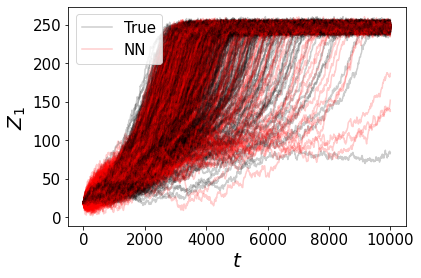

In [82]:
fig=plt.figure(figsize=(4.32*1.4,2.88*1.4))
plt.plot(vect,Z1_test[0,:],color = 'black',alpha = 0.2 ,label='True')
plt.plot(vect,Z1[0,:],color = 'red',alpha = 0.2,label='NN' )
for i in range(0,N_tra):
    plt.plot(vect,Z1[i,:],color = 'red',alpha = 0.2)
    plt.plot(vect,Z1_test[i,:],color = 'black',alpha = 0.2)
font = {'family': 'Times New Roman',  'size': 15}
legend = plt.legend(loc='upper left',prop=font)
plt.xlabel('$t$',fontsize='20') 
plt.ylabel('$Z_1$ ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('Z1_tra_3d_241_onsager50.png',bbox_inches = 'tight',dpi=300)
fig.savefig('Z1_tra_3d_241_onsager50.pdf',bbox_inches = 'tight',dpi=300)

In [ ]:
fig = plt.figure()
plt.plot(vect,Z2_test[0,:],color = 'black',alpha = 0.2 ,label='True')
plt.plot(vect,Z2[0,:],color = 'red',alpha = 0.2,label='NN' )
for i in range(0,N_tra):
    plt.plot(vect,Z2[i,:],color = 'red',alpha = 0.2)
    plt.plot(vect,Z2_test[i,:],color = 'black',alpha = 0.2)
font = {'family': 'Times New Roman',  'size': 15}
legend = plt.legend(loc='upper left',prop=font)


plt.xlabel('$t$',fontsize='20') 
plt.ylabel('$Z_2$ ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('Z2_tra_3d_241_onsager50.png',bbox_inches = 'tight',dpi=300)

In [ ]:
fig = plt.figure()
plt.plot(vect,Z3_test[0,:],color = 'black',alpha = 0.2 ,label='True')
plt.plot(vect,Z3[0,:],color = 'red',alpha = 0.2,label='NN' )
for i in range(0,N_tra):
    plt.plot(vect,Z3[i,:],color = 'red',alpha = 0.2)
    plt.plot(vect,Z3_test[i,:],color = 'black',alpha = 0.2)
font = {'family': 'Times New Roman',  'size': 15}
legend = plt.legend(loc='upper right',prop=font)


plt.xlabel('$t$',fontsize='20') 
plt.ylabel('$Z_3$ ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('Z3_tra_3d_241_onsager50.png',bbox_inches = 'tight',dpi=300)

# Potential

In [32]:
V_potential_test=np.zeros([500,1001])
V_potential =np.zeros([500,1001])

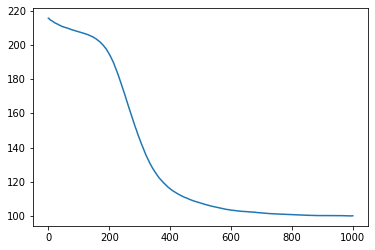

In [33]:
for i in range(0,1001):
    for j in range(0,500):
        X=np.array([ (Z1[j,i] -ex_mean )/ex_std,Z2[j,i],Z3[j,i]])[None,:]
        V_potential[j,i]=neural_potential(X, weights_potential, biases_potential,Gamma,beta)
plt.plot( np.mean(V_potential,0)  )

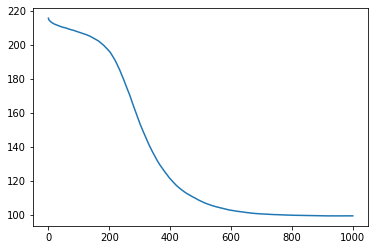

In [34]:
for i in range(0,1001):
    for j in range(0,500):
        X=np.array([(Z1_test[j,i] -ex_mean )/ex_std,Z2_test[j,i],Z3_test[j,i]])[None,:]
        V_potential_test[j,i]=neural_potential(X, weights_potential, biases_potential,Gamma,beta)
plt.plot( np.mean(V_potential_test,0)  )

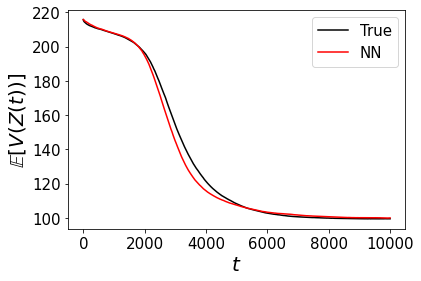

In [83]:
fig=plt.figure(figsize=(4.32*1.4,2.88*1.4))
plt.plot(vect, np.mean(V_potential_test,0),color = 'black' ,label='True' )
plt.plot( vect,np.mean(V_potential,0) ,color = 'red' ,label='NN' )

font = {'family': 'Times New Roman',  'size': 15}
plt.legend(loc='upper right',prop=font)
plt.xlabel('$t$',fontsize='20') 
plt.ylabel('$\mathbb{E}[V(Z(t))]$ ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('Z1_potential_3d_241_onsager50.png',bbox_inches = 'tight',dpi=300)  
fig.savefig('Z1_potential_3d_241_onsager50.pdf',bbox_inches = 'tight',dpi=300) 

# Z1 mean

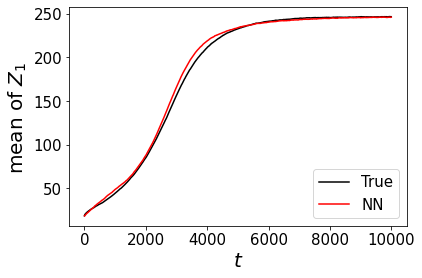

In [84]:
Z1_NN_mean=np.mean(Z1,0);
Z1_test_mean=np.mean(Z1_test,0);
fig=plt.figure(figsize=(4.32*1.4,2.88*1.4))
plt.plot(vect,Z1_test_mean ,color = 'black',label='True')
plt.plot(vect,Z1_NN_mean,color = 'red' ,label='NN' )
font = {'family': 'Times New Roman',  'size': 15}
legend = plt.legend(loc='lower right',prop=font)
plt.xlabel('$t$',fontsize='20') 
plt.ylabel('mean of $Z_1$ ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('Z1_mean_3d_241_onsager50.png',bbox_inches = 'tight',dpi=300)
fig.savefig('Z1_mean_3d_241_onsager50.pdf',bbox_inches = 'tight',dpi=300)
 
 


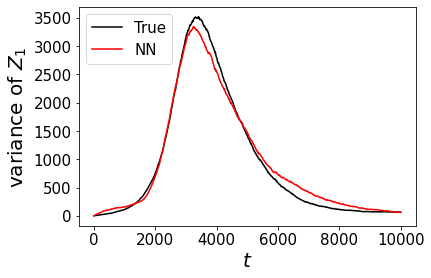

In [85]:
Z1_NN_var=np.var(Z1,0);
Z1_test_var=np.var(Z1_test,0);
fig=plt.figure(figsize=(4.32*1.4,2.88*1.4))
plt.plot(vect,Z1_test_var ,color = 'black',label='True')
plt.plot(vect,Z1_NN_var,color = 'red' ,label='NN' )
font = {'family': 'Times New Roman',  'size': 15}
plt.legend(loc='upper left',prop=font)
plt.xlabel('$t$',fontsize='20') 
plt.ylabel('variance of $Z_1$ ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('Z1_var_3d_241_onsager50.png',bbox_inches = 'tight',dpi=300)
fig.savefig('Z1_var_3d_241_onsager50.pdf',bbox_inches = 'tight',dpi=300) 

In [63]:
Z1_NN_cov=np.cov(Z1.T);
Z1_test_cov=np.cov(Z1_test.T);
a1=Z1_test_cov.min()
b1=Z1_test_cov.max()

a2=Z1_NN_cov.min()
b2=Z1_NN_cov.max()
a=min(a1,a2)
b=max(b1,b2)

In [64]:
a1,b1,a2,b2

(-6.412834039278555, 3526.8819219494994, -91.622714328601, 3347.311400936396)

# Covariance

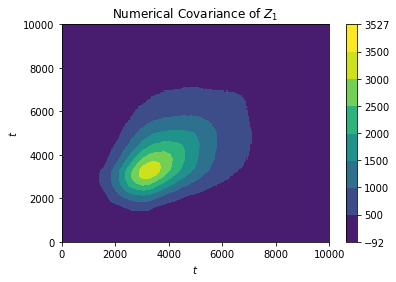

In [65]:
fig = plt.figure()
plt.contourf(vect,vect,Z1_NN_cov  ,20 , levels=[a, 500,1000, 1500,2000,2500,3000,3500,b])
plt.colorbar;
#mpl.colorbar
plt.xlabel('$t$')
plt.ylabel('$t$')
plt.title('Numerical Covariance of $Z_1$')#, 'interpreter', 'latex', 'fontsize', 16);
plt.colorbar();

# xlabel('$t$','interpreter','latex','fontsize',16)
# ylabel('$t$','interpreter','latex','fontsize',16)
# title('\mbox{Numerical Covariance of $Z_1$ }  ', 'interpreter', 'latex', 'fontsize', 16);
fig.savefig('Z1_cov_NN_3d_241_onsager50.png')

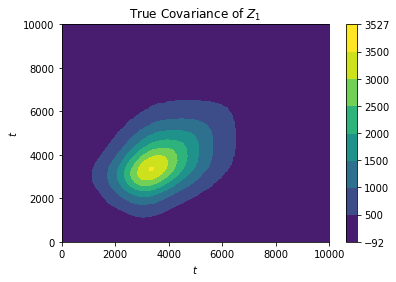

In [66]:
fig = plt.figure()
#imagesc.(vect,vect,Z1_test_cov,[a,b]  )
#norm = cm.colors.Normalize(vmax=5200, vmin=-20)
plt.contourf(vect,vect,Z1_test_cov ,20, levels=[a, 500,1000, 1500,2000,2500,3000,3500, b])
#mpl.colorbar
plt.xlabel('$t$')
plt.ylabel('$t$')
plt.title('True Covariance of $Z_1$')#, 'interpreter', 'latex', 'fontsize', 16);
#plt.axis('equal')
plt.colorbar();
# plt.zlim(-20, 5000)
# xlabel('$t$','interpreter','latex','fontsize',16)
# ylabel('$t$','interpreter','latex','fontsize',16)
# title('\mbox{Numerical Covariance of $Z_1$ }  ', 'interpreter', 'latex', 'fontsize', 16);
fig.savefig('Z1_cov_true_3d_241_onsager50.png')

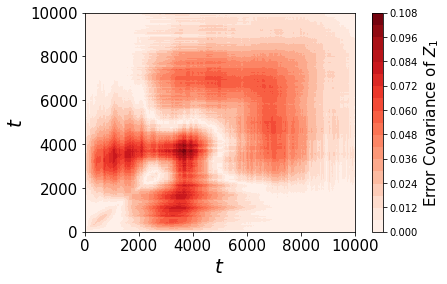

In [86]:
fig=plt.figure(figsize=(4.32*1.4,2.88*1.4))
plt.contourf(vect,vect,np.abs(Z1_NN_cov-Z1_test_cov)/ Z1_test_cov.max() ,20,cmap ="Reds")
 
#plt.title('Error Covariance of $Z_1$',fontsize='20')#, 'interpreter', 'latex', 'fontsize', 16);
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(['0.04','0.08','0.12','0.16','0.2','0.24','0.28','>0.30'],fontsize=14)
cbar.set_label('Error Covariance of $Z_1$', fontsize=15)

plt.xlabel('$t$',fontsize='20') 
plt.ylabel('$t$ ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend()#frameon=False)
fig.savefig('Z1_cov_Rerror_3d_241_onsager50.png',bbox_inches = 'tight',dpi=300)
fig.savefig('Z1_cov_Rerror_3d_241_onsager50.pdf',bbox_inches = 'tight',dpi=300)

# L1 error
mean: Z1_NN_mean     Z1_test_mean

In [87]:
Z1_mean_error=abs(Z1_NN_mean-Z1_test_mean)


Z1_mean_L1_error=np.sum(Z1_mean_error)/np.sum(Z1_test_mean);
Z1_mean_L2_error=np.sqrt(  np.sum(Z1_mean_error**2)/np.sum(Z1_test_mean**2)  );
Z1_mean_inf_error=np.max(Z1_mean_error)/np.max(Z1_test_mean);
Z1_mean_error=np.mean(Z1_mean_error)/np.max(Z1_test_mean);

In [88]:
np.max(Z1_test_mean)

246.82242000000014

In [89]:
Z1_cov_error=abs( Z1_NN_cov- Z1_test_cov )
Z1_cov_L1_error=np.sum(Z1_cov_error ) /np.sum(Z1_test_cov) 
Z1_cov_L2_error=np.sqrt( np.sum(Z1_cov_error**2) /np.sum(Z1_test_cov**2))  
Z1_cov_inf_error=np.max(Z1_cov_error ) /np.max(Z1_test_cov) 
Z1_cov_mean_error=np.mean(Z1_cov_error ) /np.max(Z1_test_cov) 

In [90]:
np.array([Z1_mean_L1_error,Z1_mean_L2_error,Z1_mean_inf_error,Z1_mean_error ,Z1_cov_L1_error,Z1_cov_L2_error,Z1_cov_inf_error,Z1_cov_mean_error ])

#0.02388991, 0.0258118 , 0.03746046, 0.01770628, 0.54057141, 0.49437255, 0.3699703 , 0.08412784

array([0.0159834 , 0.0210053 , 0.04319062, 0.01193464, 0.2307392 ,
       0.15446555, 0.10685797, 0.02377253])

# Unfolding time

In [91]:
dt=10000/1000
Length=246.09

In [92]:
t_test=np.zeros(N_tra)[:,None]
t_NN=np.zeros(N_tra)[:,None]
for i in range(N_tra):
    a=np.where(Z1[i,:]>Length)
    if len(a[0])==0:
        t_NN[i]=10000
    else:
        t_NN[i]=dt*(a[0][0])
    b=np.where(Z1_test[i,:]>Length)
    if len(b[0])==0:
        t_test[i]=10000
    else:
        t_test[i]=dt*(b[0][0]-1);

In [93]:
mean_t_NN=np.mean(t_NN)
mean_t_test=np.mean(t_test)
var_t_NN=np.var(t_NN)
var_t_test=np.var(t_test)
kernel_test = stats.gaussian_kde((t_test.T) )
kernel_NN = stats.gaussian_kde((t_NN.T) )
UT_test=kernel_test(vect)
UT_NN=kernel_NN(vect)

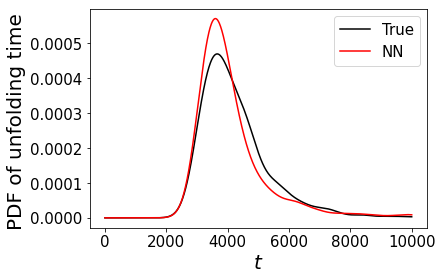

In [95]:
fig=plt.figure(figsize=(4.32*1.4,2.88*1.4))
plt.plot(vect,UT_test ,color = 'black',label='True')
plt.plot(vect,UT_NN,color = 'red' ,label='NN' )

font = {'family': 'Times New Roman',  'size': 15}
plt.legend(loc='upper right',prop=font)
plt.xlabel('$t$',fontsize='20') 
plt.ylabel('PDF of unfolding time ',fontsize='20') 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.savefig('Z1_ufTime_241_onsager50.png',bbox_inches = 'tight',dpi=300)
fig.savefig('Z1_ufTime_241_onsager50.pdf',bbox_inches = 'tight',dpi=300)

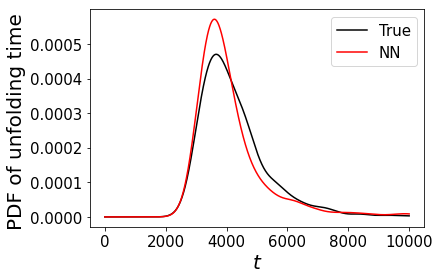

In [56]:

# fig = plt.figure()
# plt.plot(vect,UT_test ,color = 'black',label='True')
# plt.plot(vect,UT_NN,color = 'red' ,label='NN' )

# font = {'family': 'Times New Roman',  'size': 15}
# legend = plt.legend(prop={'family': 'Times New Roman',  'size': 15})
# plt.xlabel('$t$',fontsize='20') 
# plt.ylabel('PDF of unfolding time ',fontsize='20') 
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# fig.savefig('Z1_ufTime_241_onsager50.png',bbox_inches = 'tight',dpi=300)


# Potential

In [53]:
dx=1
dy=1
 
yy=np.linspace(0,300,301)#0:dy:300;
XX1=(yy-ex_mean)/ex_std
dz=0.06
XX2=np.linspace(-3,3,101)#-3:dz:3;
dzz=12/100;
XX3=np.linspace(-6,6,101)#-6:dzz:6;

In [54]:
z_poten_Z1_Z2=np.loadtxt('../../z_poten_Z1_Z2.txt');
z_poten_Z1_Z3=np.loadtxt('../../z_poten_Z1_Z3.txt');
z_poten_Z2_Z3=np.loadtxt('../../z_poten_Z2_Z3.txt');

In [ ]:
potential_min=np.min(  np.array([z_poten_Z1_Z2.min(),z_poten_Z1_Z3.min(),z_poten_Z2_Z3.min()]  )   )

potential_1max=np.max(z_poten_Z1_Z2)-potential_min
potential_1max

In [ ]:
fig = plt.figure()
plt.contourf(yy,XX2, (z_poten_Z1_Z2-potential_min).T,20,levels=[0, 30,60,90,120,150,260])
# plt.plot(Z1,Z2[0,:],color = 'red',alpha = 0.2,label='$Z_{2NN}$' )
# plt.plot(Z1_test,Z2_test[0,:],color = 'black',alpha = 0.2 ,label='$Z_{2true}$')
for i in range(0,N_tra):
    plt.plot(Z1[i,:],Z2[i,:],color = 'red',alpha = 0.2)
    plt.plot(Z1_test[i,:],Z2_test[i,:],color = 'black',alpha = 0.2)
plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')
plt.title('Potential')
plt.colorbar();
plt.show()

#plt.title('sign(Error)')
#plt.colorbar();
fig.savefig('Z1_Z2_path_3d_241_onsager50')


#fig.savefig('A-2-2-2-1-T01_all.png')

In [ ]:
fig = plt.figure()
plt.contourf(yy,XX3, (z_poten_Z1_Z3-potential_min).T,20,levels=[0, 30,60,90,120,150,260])
# plt.plot(Z1,Z2[0,:],color = 'red',alpha = 0.2,label='$Z_{2NN}$' )
# plt.plot(Z1_test,Z2_test[0,:],color = 'black',alpha = 0.2 ,label='$Z_{2true}$')
for i in range(0,N_tra):
    plt.plot(Z1[i,:],Z3[i,:],color = 'red',alpha = 0.2)
    plt.plot(Z1_test[i,:],Z3_test[i,:],color = 'black',alpha = 0.2)
plt.xlabel('$Z_1$')
plt.ylabel('$Z_3$')
plt.title('Potential')
plt.colorbar();
plt.show()

#plt.title('sign(Error)')
#plt.colorbar();
fig.savefig('Z1_Z3_path_3d_241_onsager50.png')


#fig.savefig('A-2-2-2-1-T01_all.png')

In [ ]:
fig = plt.figure()
plt.contourf(XX2,XX3, (z_poten_Z2_Z3-potential_min).T,20, levels=[0, 30,60,90,120,150,260])
# plt.plot(Z1,Z2[0,:],color = 'red',alpha = 0.2,label='$Z_{2NN}$' )
# plt.plot(Z1_test,Z2_test[0,:],color = 'black',alpha = 0.2 ,label='$Z_{2true}$')
for i in range(0,N_tra):
    plt.plot(Z2[i,:],Z3[i,:],color = 'red',alpha = 0.2)
    plt.plot(Z2_test[i,:],Z3_test[i,:],color = 'black',alpha = 0.2)
plt.xlabel('$Z_2$')
plt.ylabel('$Z_3$')
plt.title('Potential')
plt.colorbar();
plt.show()

#plt.title('sign(Error)')
#plt.colorbar();
fig.savefig('Z2_Z3_path_3d_241_onsager50')


#fig.savefig('A-2-2-2-1-T01_all.png')